/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore




Sim time: 0.0, Dt: 0.01 (days)
350.0, 350.0
sticking: 31, sliding: 0, open: 0


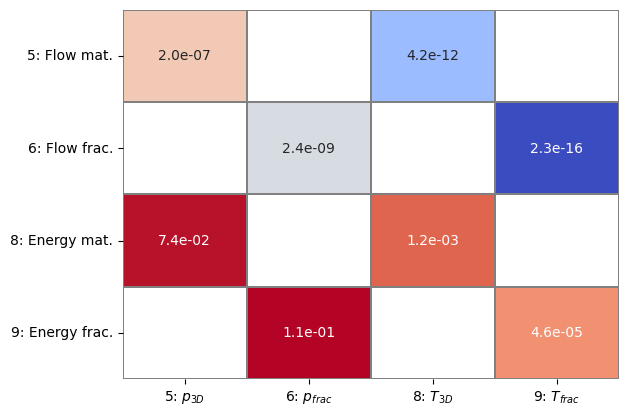

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal.thermal_runscript_2 import make_model
import porepy as pp


model = make_model(
    {
        "geometry": 0.2,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]

temp = [8, 9]
flow = [5, 6]

J = model.bmat[flow + temp]
J.plot_max()

In [3]:
import petsc4py

petsc4py.init()
from petsc4py import PETSc
from mat_utils import make_сlear_petsc_options

options = {
    'ksp_monitor': None,
    'ksp_pc_side': 'right',
    'ksp_rtol': 1e-10,
    'ksp_type': 'gmres',
    'pc_type': 'composite',
    'pc_composite_type': 'multiplicative',
    'pc_composite_pcs': 'fieldsplit,ilu',
    # pressure
    'sub_0_ksp_type': 'preonly',
    'sub_0_pc_fieldsplit_type': 'additive',
    'sub_0_fieldsplit_flow_ksp_type': 'preonly',
    'sub_0_fieldsplit_flow_pc_type': 'hypre',
    'sub_0_fieldsplit_flow_pc_hypre_type': 'boomeramg',
    'sub_0_fieldsplit_temp_ksp_type': 'preonly',
    'sub_0_fieldsplit_temp_pc_type': 'none',
}
subsolver_options = make_сlear_petsc_options()
for k, v in options.items():
    subsolver_options[k] = v 

petsc_ksp = PETSc.KSP().create()
petsc_pc = petsc_ksp.pc
petsc_mat = PETSc.Mat().createAIJ(
    size=J.shape,
    csr=(J.mat.indptr, J.mat.indices, J.mat.data),
    bsize=1,
)

rhs_local = J.project_rhs_to_local(rhs)

petsc_rhs = petsc_mat.createVecLeft()
petsc_x0 = petsc_mat.createVecLeft()
petsc_rhs.setArray(rhs_local)
# petsc_rhs.set(1.0)
petsc_x0.set(0.0)

dofs_flow = np.concatenate([J.local_dofs_row[x] for i in flow for x in J.groups_to_blocks_row[i]], dtype=np.int32)
dofs_temp = np.concatenate([J.local_dofs_row[x] for i in temp for x in J.groups_to_blocks_row[i]], dtype=np.int32)
isflow = PETSc.IS().createGeneral(dofs_flow)
istemp = PETSc.IS().createGeneral(dofs_temp)

petsc_ksp.setOperators(petsc_mat)
petsc_ksp.setFromOptions()
fieldsplit = petsc_pc.getCompositePC(0)
fieldsplit.setFieldSplitIS(('temp', istemp), ('flow', isflow))
petsc_ksp.setUp()
petsc_pc.setUp()
fieldsplit.setUp()

# petsc_ksp.setConvergenceHistory()
# petsc_ksp.view()

In [4]:
petsc_ksp.solve(petsc_rhs, petsc_x0)

petsc_ksp.getConvergedReason()

  0 KSP Residual norm 1.039899263855e-04 
  1 KSP Residual norm 7.431746399164e-10 
  2 KSP Residual norm 1.351517388753e-13 
  3 KSP Residual norm 3.539309344761e-17 


2

In [5]:
petsc_ksp.view()

KSP Object: 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=10000, initial guess is zero
  tolerances:  relative=1e-10, absolute=1e-50, divergence=10000.
  right preconditioning
  using UNPRECONDITIONED norm type for convergence test
PC Object: 1 MPI process
  type: composite
  Composite PC type - MULTIPLICATIVE
  PCs on composite preconditioner follow
  ---------------------------------
    PC Object: (sub_0_) 1 MPI process
      type: fieldsplit
        FieldSplit with ADDITIVE composition: total splits = 2
        Solver info for each split is in the following KSP objects:
      Split number 0 Defined by IS
      KSP Object: (sub_0_fieldsplit_temp_) 1 MPI process
        type: preonly
        maximum iterations=10000, initial guess is zero
        tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
        left preconditioning
     

In [6]:
from dataclasses import dataclass
from typing import Optional
from block_matrix import BlockMatrixStorage

from full_petsc_solver import (
    PetscFieldSplitScheme,
    build_tag,
    construct_is,
    insert_petsc_options,
)




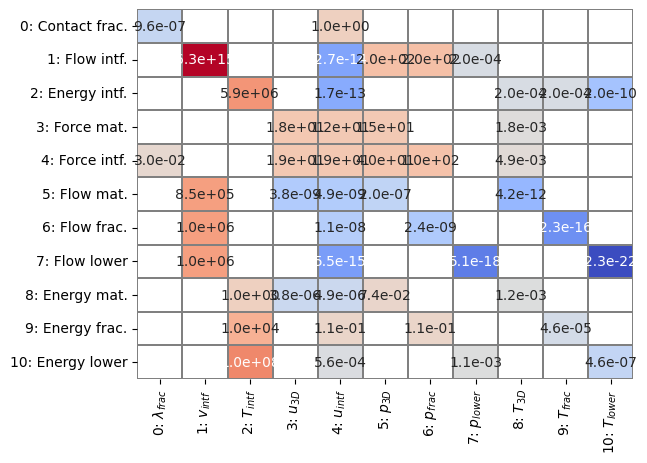

In [7]:
contact = [0]
intf = [1,2]
temp = [8, 9, 10]
flow = [5, 6, 7]
mech = [3, 4]

J = model.bmat[contact + intf + mech + flow + temp]
J.plot_max()

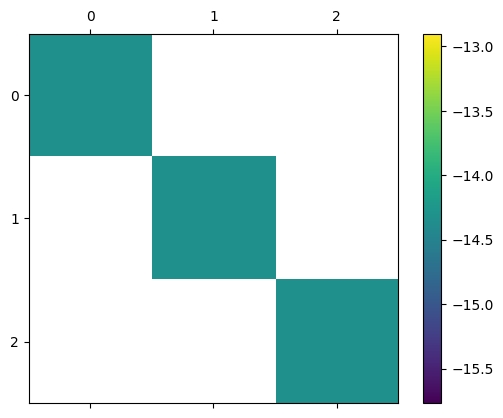

In [8]:
J[[10]].matshow()

In [ ]:
from full_petsc_solver import (
    LinearTransformedScheme,
    PetscCPRScheme,
    PetscFieldSplitScheme,
    PetscKSPScheme,
)
from fixed_stress import make_fs_analytical, make_fs_analytical_slow_new
from mat_utils import csr_to_petsc


scheme = LinearTransformedScheme(
    right_transformations=[lambda bmat: model.Qright(contact_group=0, u_intf_group=4)],
    inner=PetscKSPScheme(
        petsc_options={
            # 'ksp_type': 'fgmres',
            # "ksp_pc_side": "right",
            "ksp_monitor": None,
        },
        preconditioner=PetscFieldSplitScheme(
            groups=[0],
            block_size=model.nd,
            fieldsplit_options={
                "pc_fieldsplit_schur_precondition": "selfp",
            },
            subsolver_options={
                "pc_type": "pbjacobi",
            },
            tmp_options={
                "mat_schur_complement_ainv_type": "blockdiag",
            },
            complement=PetscFieldSplitScheme(
                groups=intf,
                subsolver_options={
                    "pc_type": "ilu",
                },
                fieldsplit_options={
                    "pc_fieldsplit_schur_precondition": "selfp",
                },
                complement=PetscFieldSplitScheme(
                    groups=mech,
                    subsolver_options={
                        "pc_type": "hypre",
                        "pc_hypre_type": "boomeramg",
                        "pc_hypre_boomeramg_strong_threshold": 0.7,
                    },
                    block_size=model.nd,
                    invert=lambda bmat: csr_to_petsc(
                        make_fs_analytical_slow_new(
                            model,
                            bmat,
                            p_mat_group=5,
                            p_frac_group=6,
                            groups=flow + temp,
                        ).mat,
                        bsize=1,
                    ),
                    complement=PetscCPRScheme(
                        groups=flow + temp,
                        pressure_groups=flow,
                        pressure_options={
                            "ksp_type": "preonly",
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                        },
                        others_options={
                            "ksp_type": "preonly",
                            "pc_type": "none",
                        },
                    ),
                ),
            ),
        ),
    ),
)
petsc_ksp = scheme.make_solver(mat_orig=J)
scheme.options

{'ksp_type': 'gmres',
 'ksp_pc_side': 'right',
 'ksp_rtol': 1e-10,
 'ksp_max_it': 120,
 'ksp_gmres_cgs_refinement_type': 'refine_ifneeded',
 'ksp_gmres_classicalgramschmidt': True,
 'ksp_monitor': None,
 'pc_type': 'fieldsplit',
 'pc_fieldsplit_type': 'schur',
 'pc_fieldsplit_schur_precondition': 'selfp',
 'pc_fieldsplit_schur_fact_type': 'upper',
 'fieldsplit_0_ksp_type': 'preonly',
 'fieldsplit_0_pc_type': 'pbjacobi',
 'fieldsplit_1-2-3-4-5-6-8-9_ksp_type': 'preonly',
 'fieldsplit_1-2-3-4-5-6-8-9_mat_schur_complement_ainv_type': 'blockdiag',
 'fieldsplit_1-2-3-4-5-6-8-9_pc_type': 'fieldsplit',
 'fieldsplit_1-2-3-4-5-6-8-9_pc_fieldsplit_type': 'schur',
 'fieldsplit_1-2-3-4-5-6-8-9_pc_fieldsplit_schur_precondition': 'selfp',
 'fieldsplit_1-2-3-4-5-6-8-9_pc_fieldsplit_schur_fact_type': 'upper',
 'fieldsplit_1-2-3-4-5-6-8-9_fieldsplit_1-2_ksp_type': 'preonly',
 'fieldsplit_1-2-3-4-5-6-8-9_fieldsplit_1-2_pc_type': 'ilu',
 'fieldsplit_1-2-3-4-5-6-8-9_fieldsplit_3-4-5-6-8-9_ksp_type': 'preo

In [126]:
petsc_ksp.ksp.view()

KSP Object: 1 MPI process
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with one step of iterative refinement when needed
    happy breakdown tolerance 1e-30
  maximum iterations=120, initial guess is zero
  tolerances:  relative=1e-10, absolute=1e-50, divergence=10000.
  right preconditioning
  using UNPRECONDITIONED norm type for convergence test
PC Object: 1 MPI process
  type: fieldsplit
    FieldSplit with Schur preconditioner, factorization UPPER
    Preconditioner for the Schur complement formed from Sp, an assembled approximation to S, which uses A00's block diagonal's inverse
    Split info:
    Split number 0 Defined by IS
    Split number 1 Defined by IS
    KSP solver for A00 block
      KSP Object: (fieldsplit_0_) 1 MPI process
        type: preonly
        maximum iterations=10000, initial guess is zero
        tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
        left preconditioning
        using DEFAULT norm 

In [127]:
rhs_local = J.project_rhs_to_local(rhs)
petsc_ksp.solve(rhs_local)

petsc_ksp.ksp.getConvergedReason()

  0 KSP Residual norm 1.555011520320e+01 
  1 KSP Residual norm 2.848473043199e+00 
  2 KSP Residual norm 3.675337305072e-01 
  3 KSP Residual norm 9.476691131449e-02 
  4 KSP Residual norm 2.158203280013e-02 
  5 KSP Residual norm 9.603742719725e-03 
  6 KSP Residual norm 5.509163748510e-03 
  7 KSP Residual norm 2.146795604509e-03 
  8 KSP Residual norm 8.692094554373e-04 
  9 KSP Residual norm 2.751996415688e-04 
 10 KSP Residual norm 6.697888287443e-05 
 11 KSP Residual norm 1.172493797487e-05 
 12 KSP Residual norm 2.470427343248e-06 
 13 KSP Residual norm 6.205268809009e-07 
 14 KSP Residual norm 1.171140373396e-07 
 15 KSP Residual norm 2.666137631257e-08 
 16 KSP Residual norm 5.232663052044e-09 
 17 KSP Residual norm 1.195255516300e-09 


2

In [84]:
from mat_utils import csr_to_petsc, inv_block_diag, petsc_to_csr
from full_petsc_solver import PetscFieldSplitScheme, build_petsc_solver


tmp = JQ[[0, 3]]
petsc_ksp, options = build_petsc_solver(
    bmat=tmp[[0, 3]],
    scheme=PetscFieldSplitScheme(
        groups=[0],
        block_size=model.nd,
        fieldsplit_options={
            "pc_fieldsplit_schur_precondition": "full",
        },
        subsolver_options={
            "pc_type": "ilu",
        },
        complement=PetscFieldSplitScheme(
            groups=[3],
            fieldsplit_options={},
            subsolver_options={
                "pc_type": "ilu",
            },
        ),
    ),
)

options

{'ksp_monitor': None,
 'ksp_type': 'gmres',
 'ksp_pc_side': 'right',
 'ksp_rtol': 1e-10,
 'ksp_max_it': 120,
 'pc_type': 'fieldsplit',
 'pc_fieldsplit_type': 'schur',
 'pc_fieldsplit_schur_precondition': 'full',
 'fieldsplit_0_ksp_type': 'preonly',
 'fieldsplit_0_pc_type': 'ilu',
 'fieldsplit_3_ksp_type': 'preonly',
 'fieldsplit_3_pc_type': 'ilu'}

In [85]:
rhs_local = tmp.project_rhs_to_local(rhs)
petsc_mat = petsc_ksp.getOperators()[0]
petsc_rhs = petsc_mat.createVecLeft()
petsc_x0 = petsc_mat.createVecLeft()
petsc_rhs.setArray(rhs_local)
petsc_x0.set(0.0)

petsc_ksp.solve(petsc_rhs, petsc_x0)

petsc_ksp.getConvergedReason()

  0 KSP Residual norm 2.565604599723e-01 
  1 KSP Residual norm 5.822082229554e-04 
  2 KSP Residual norm 2.200382521167e-05 
  3 KSP Residual norm 1.358436625500e-06 
  4 KSP Residual norm 4.020299871977e-08 
  5 KSP Residual norm 1.020923814081e-09 
  6 KSP Residual norm 5.915779440624e-11 
  7 KSP Residual norm 2.131645406433e-12 


2